# 用户指南，第9章：和弦化
[原文链接](https://web.mit.edu/music21/doc/usersGuide/usersGuide_09_chordify.html)

**和弦化**（Chordify）是music21中的一个概念，意思是将非和弦的音符整理为和弦的形式。通过这个功能，可以将包含多个音轨的总谱整理成一系列的和弦，存放在单个音轨中。下面我们使用这首巴赫的作品作为例子：

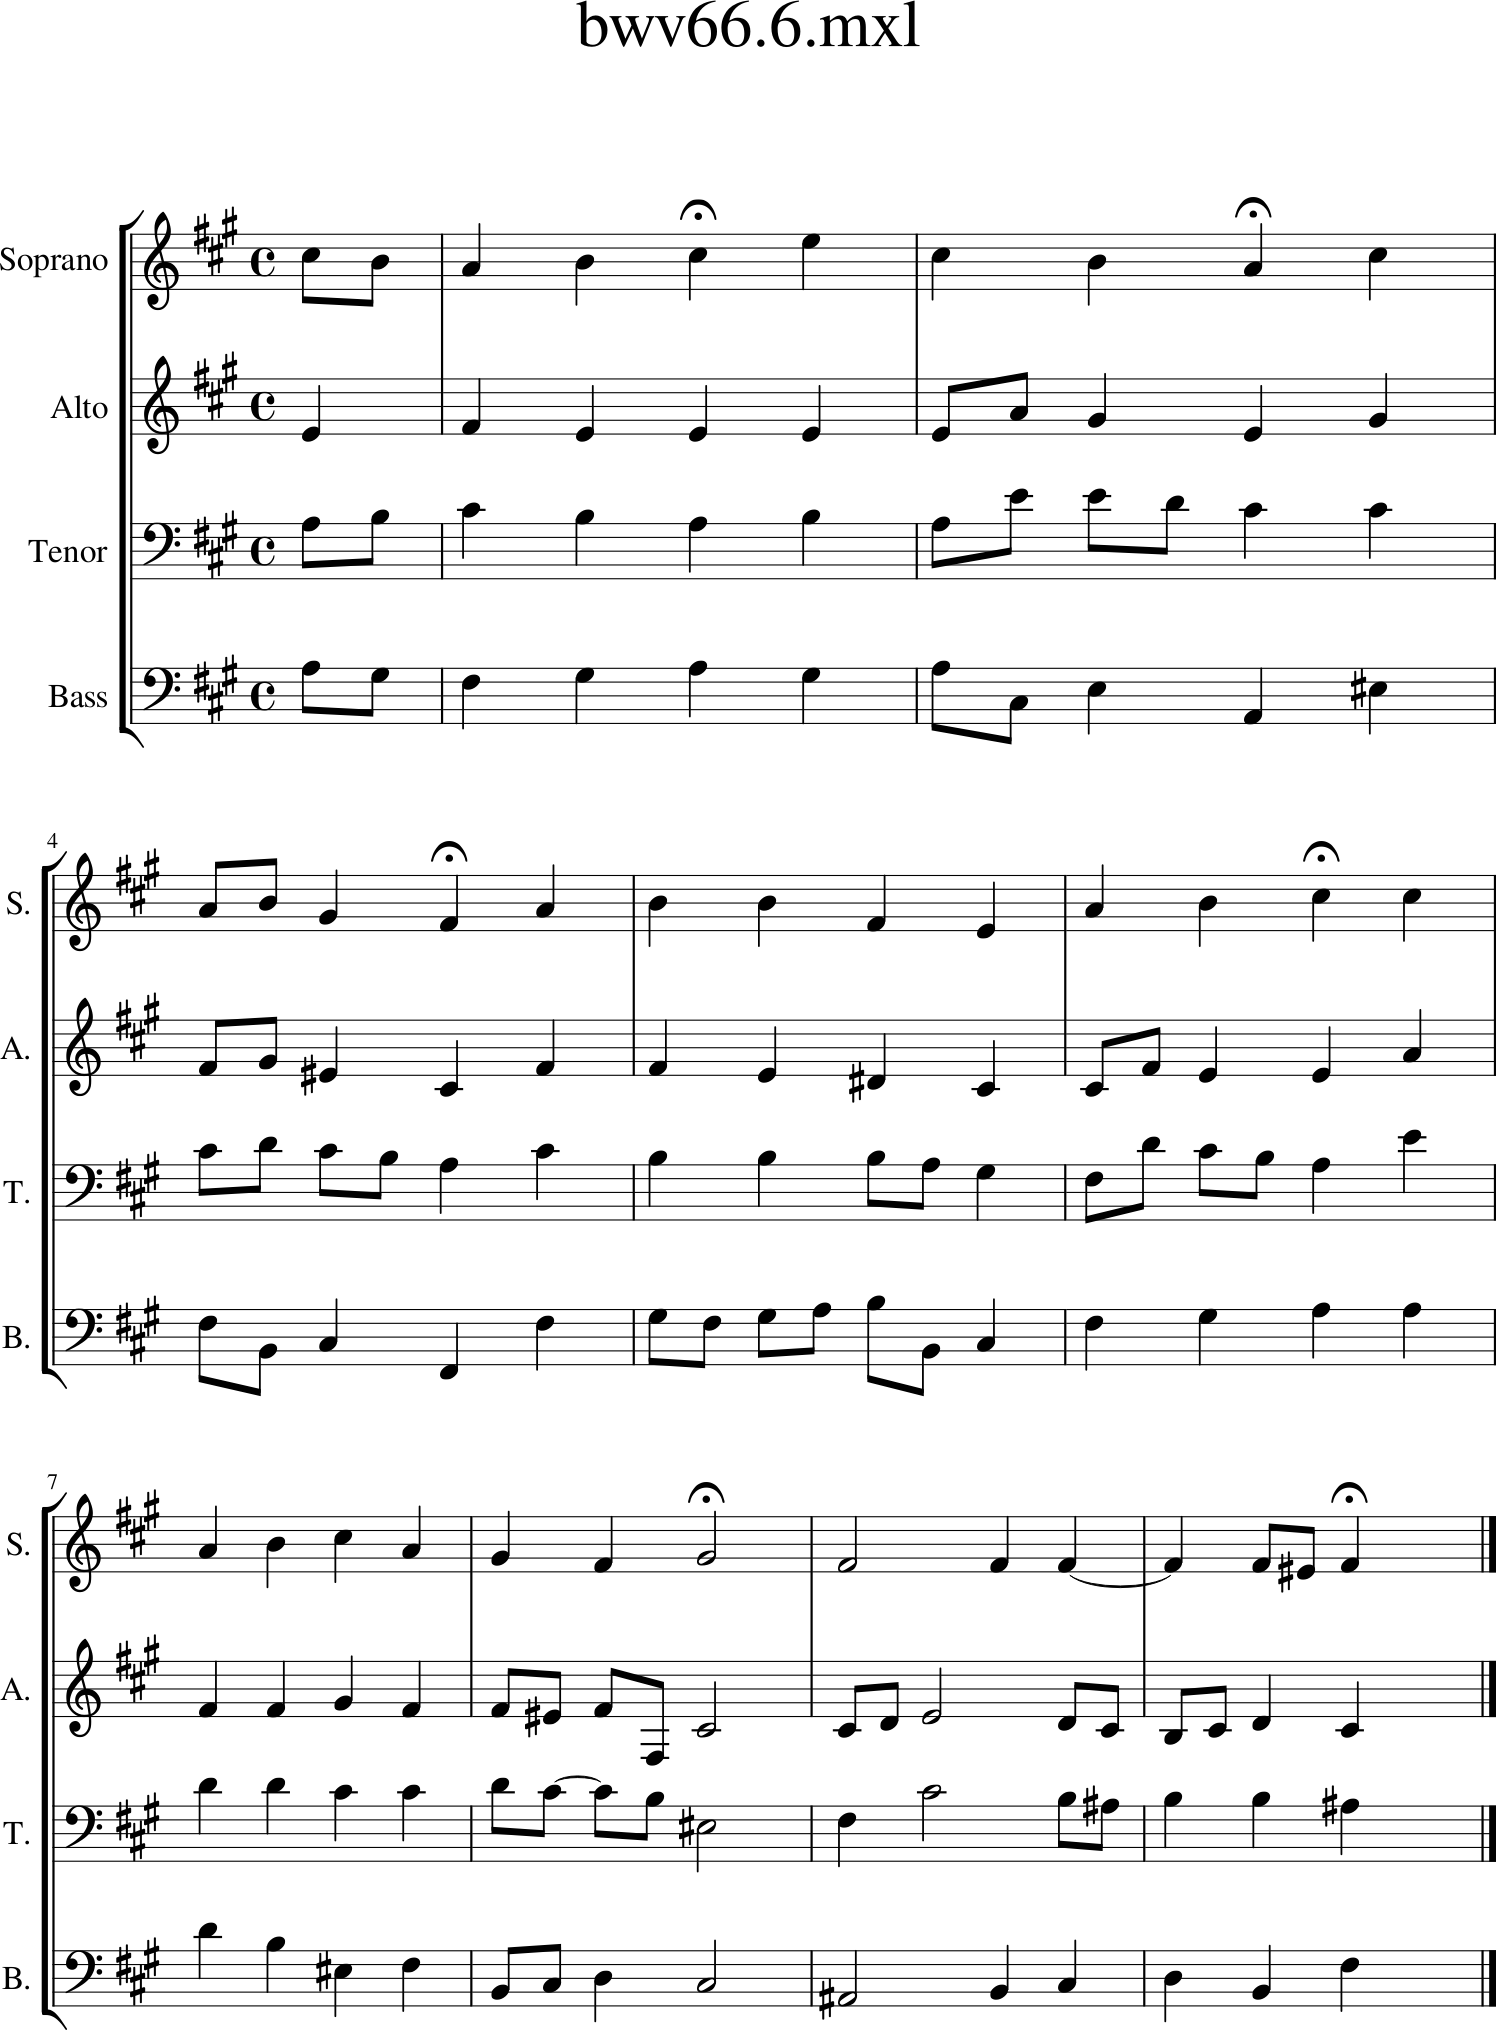

In [1]:
from music21 import *

b = corpus.parse('bwv66.6')
b.show()

使用`chordify()`函数将其和弦化：

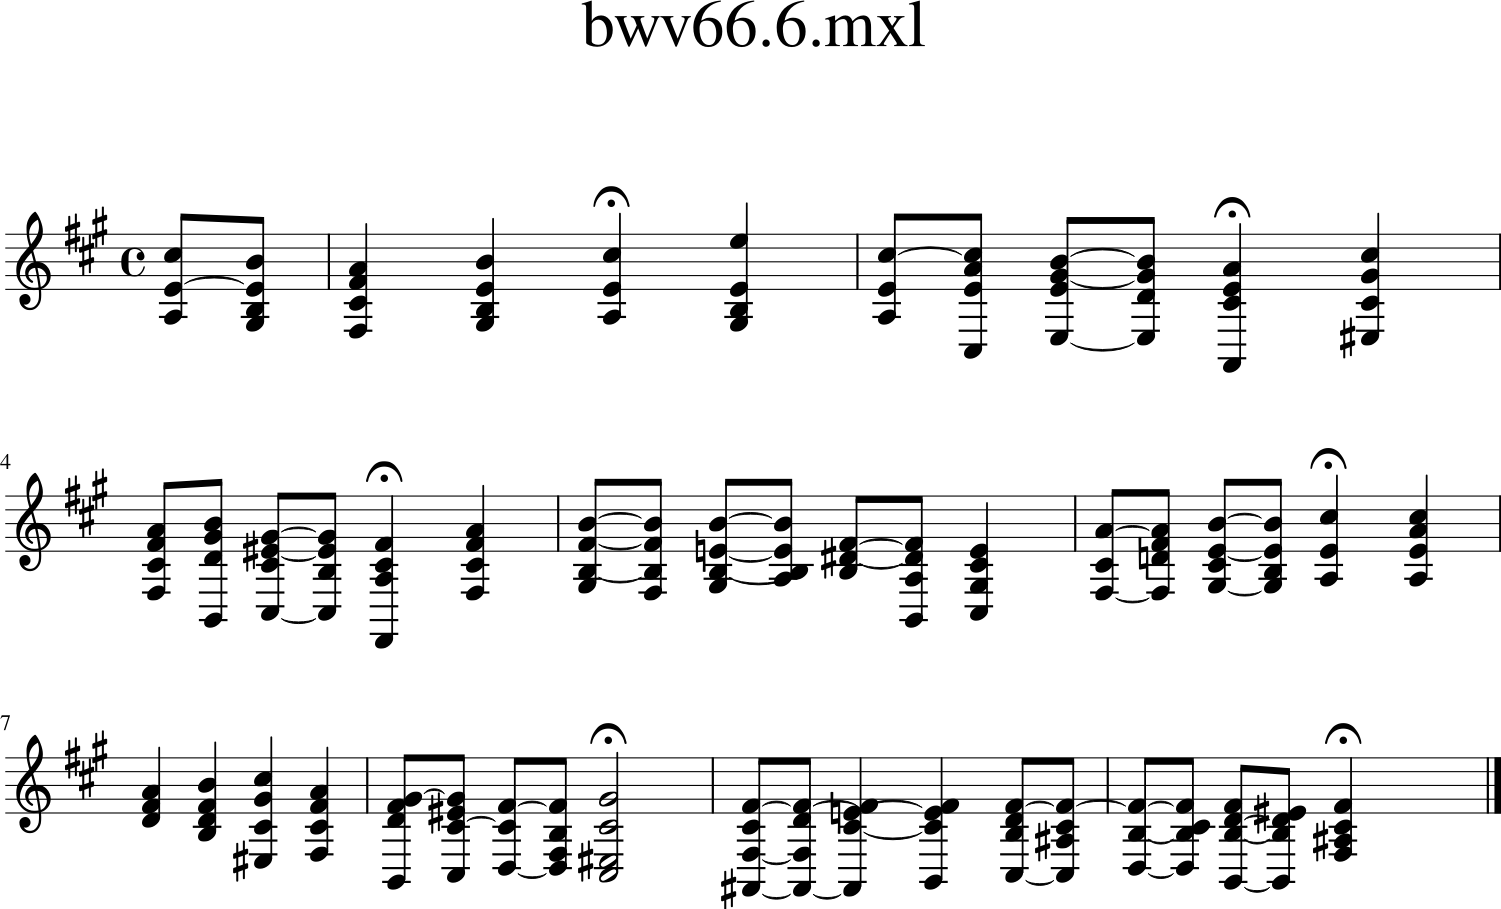

In [2]:
bChords = b.chordify()
bChords.show()

现在，乐谱中的所有音符都在和弦中表示，每个瞬间发生了什么一目了然。这种操作就像切香肠，就是把乐谱纵向切得很细，以清晰地展现每个瞬间发生的事情。

现在我们可以检查有没有（完整标记的）属七和弦。和弦化后的音轨仍然包含小节，所以我们需要递归进入音轨来获取和弦。音轨中也可能含有节拍记号，需要在检查和弦前过滤。

In [3]:
for thisChord in bChords.recurse().getElementsByClass('Chord'):
    if thisChord.isDominantSeventh():
        print(thisChord.measureNumber, thisChord.beatStr, thisChord)

2 2 1/2 <music21.chord.Chord E3 D4 G#4 B4>
3 2 1/2 <music21.chord.Chord C#3 B3 E#4 G#4>
4 3 1/2 <music21.chord.Chord B2 A3 D#4 F#4>
8 2 <music21.chord.Chord A#2 C#4 E4 F#4>


一共有四个属七和弦，其中三个在半拍上（2小节2.5拍，3小节2.5拍，4小节3.5拍），它们是由passing motion导致的。还有一个在8小节2拍，也是乐理上的弱拍。

我们可以调用`bChords`的`show()`函数来查看和弦化后的乐谱。但是，有时需要把和弦音轨与整个乐谱的上下文一起浏览。我们把它添加到总谱中（所有的音轨`Part`对象会自动从0时刻开始），然后仅显示0~4小节。

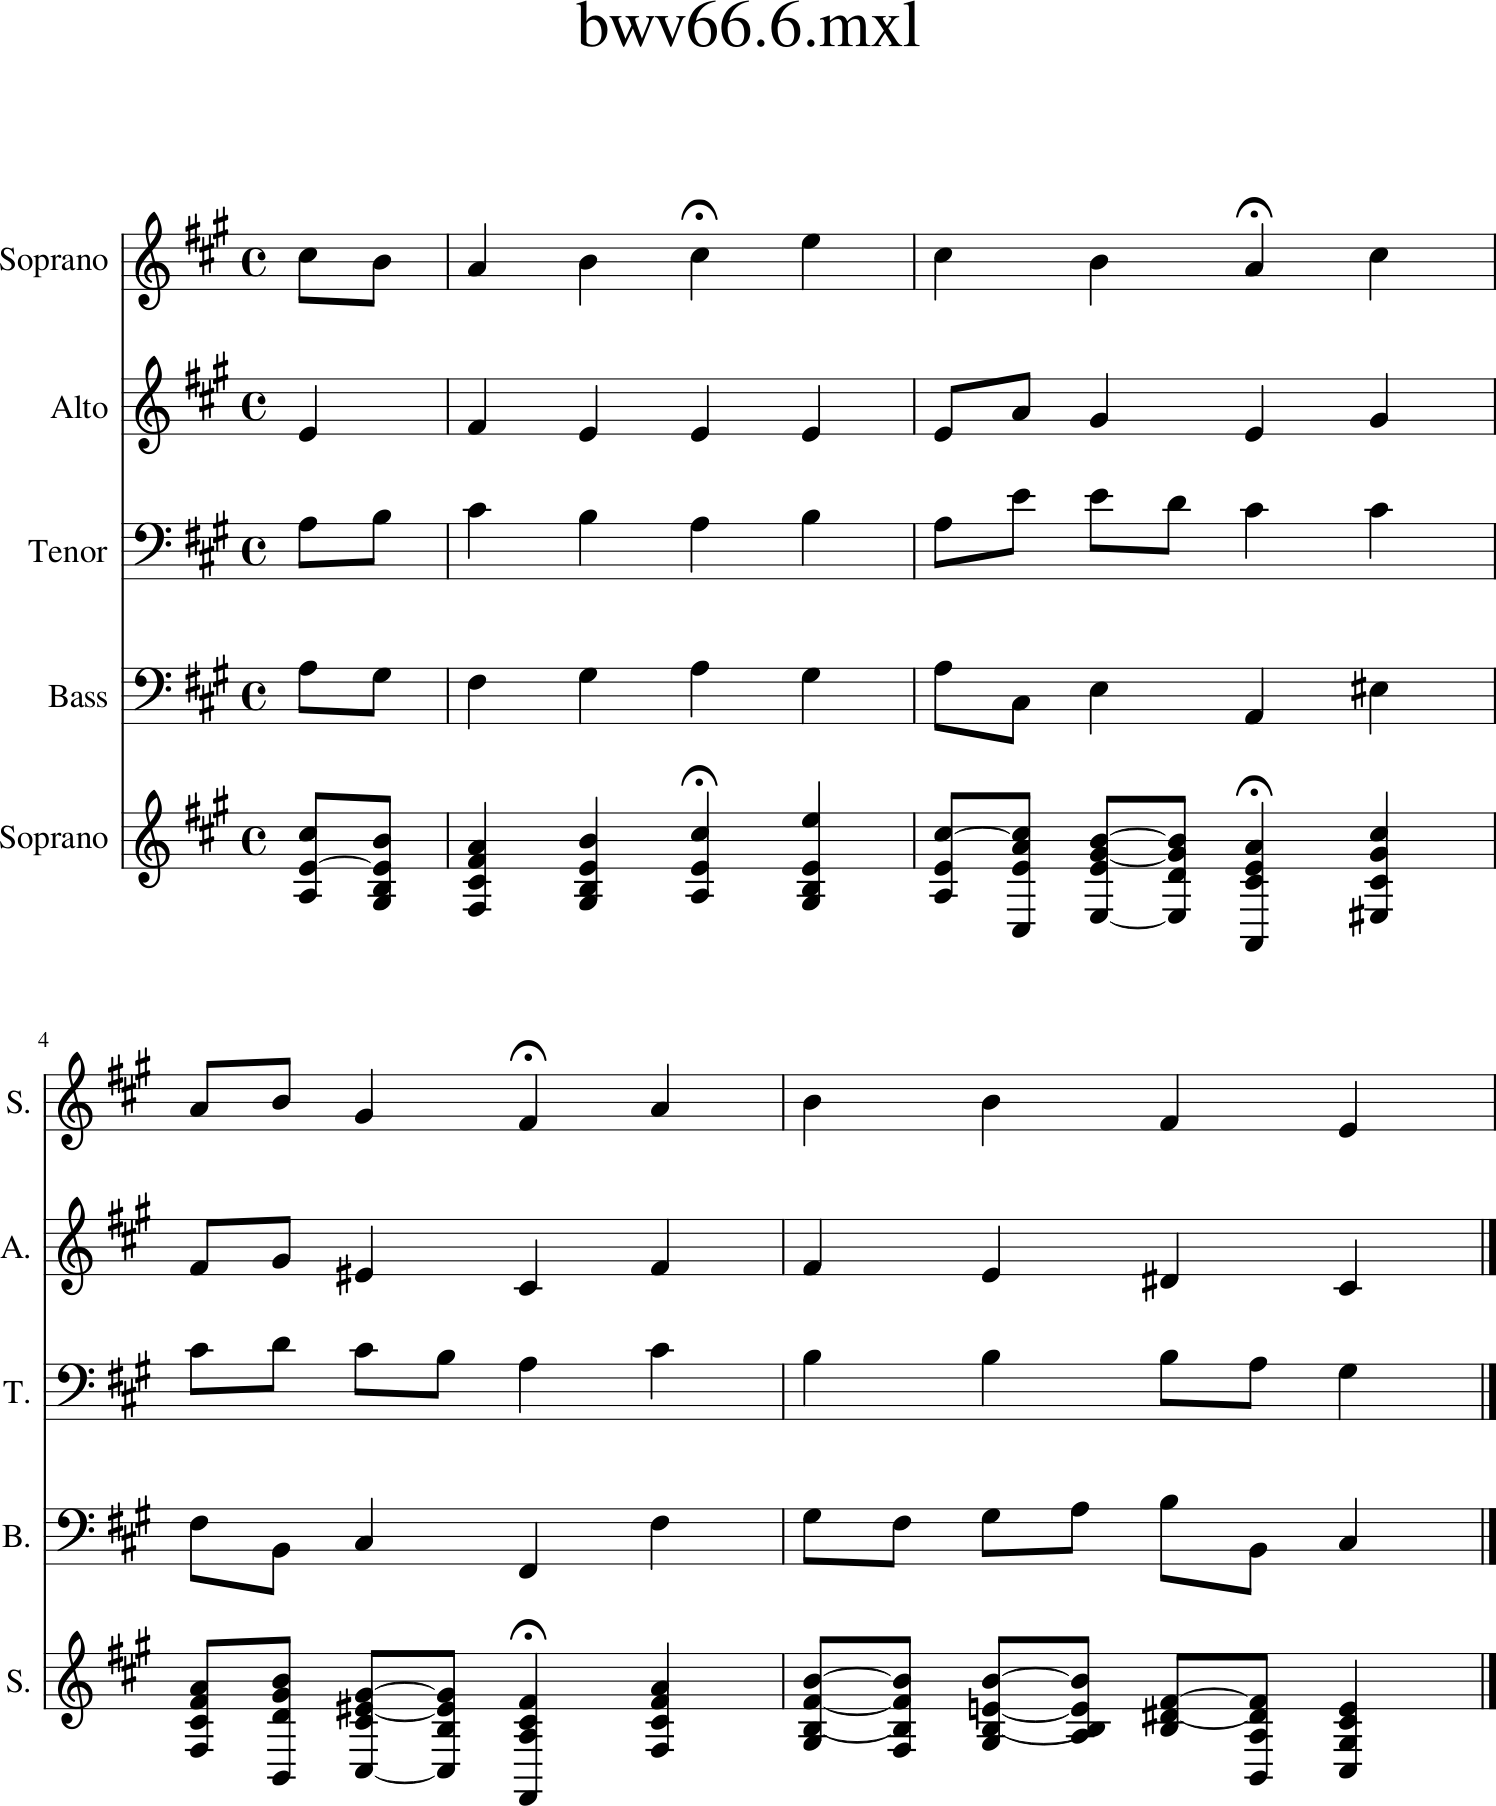

In [4]:
b.insert(0, bChords)
b.measures(0, 4).show()

乐谱有点混乱，所以我们使用`closedPosition()`把和弦缩紧（参见[第7章：和弦](07.ipynb)）

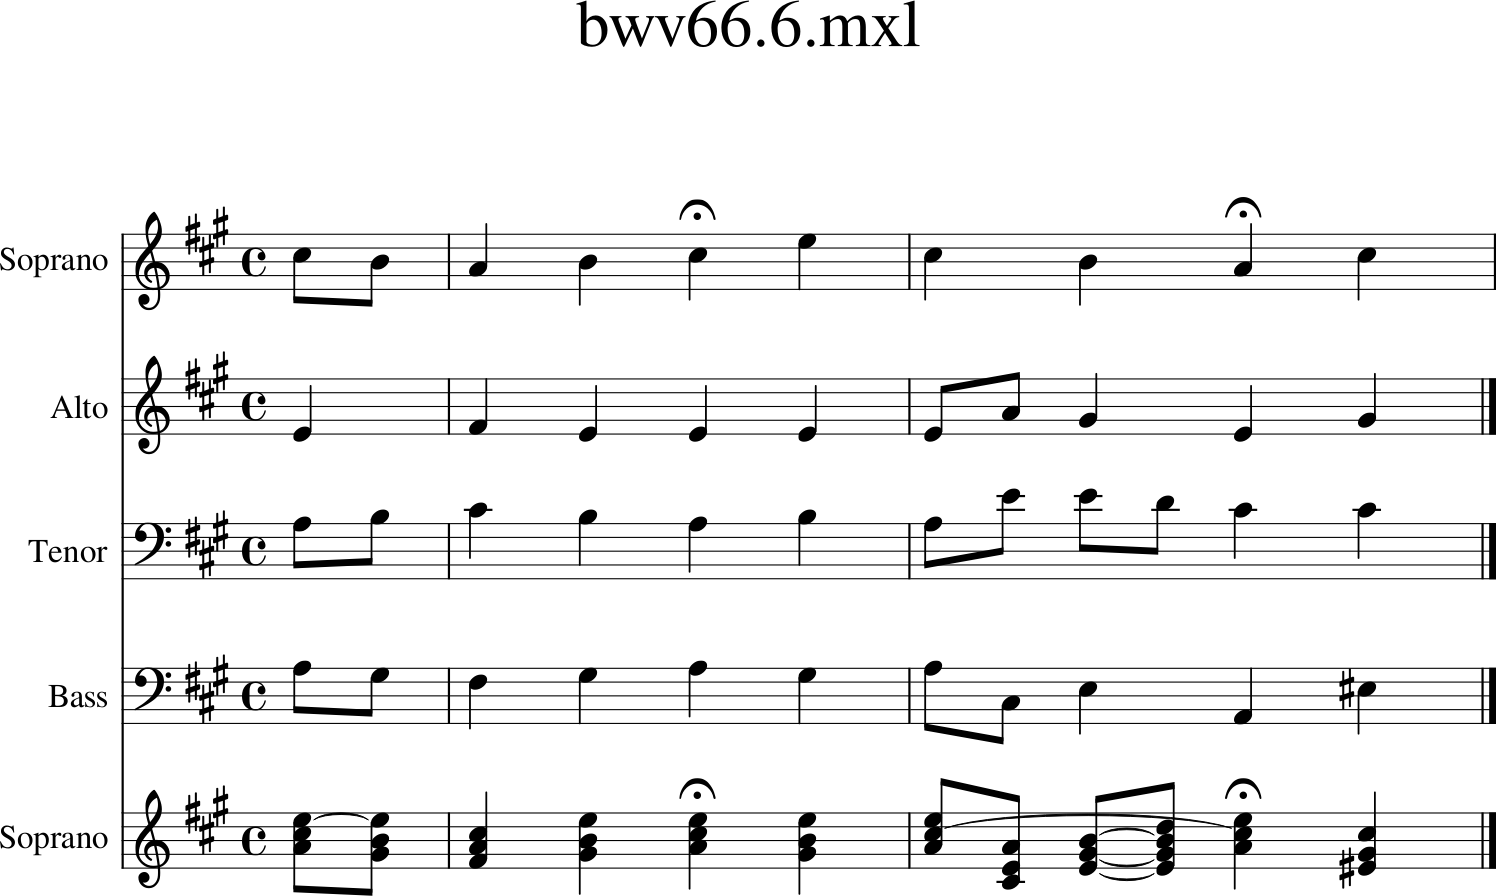

In [5]:
for c in bChords.recurse().getElementsByClass('Chord'):
    c.closedPosition(forceOctave=4, inPlace=True)

b.measures(0, 2).show()

注意当我们将和弦缩紧之后，和弦中音符的同音连音符`tie`信息丢失了。这是因为一个音符上开始的`tie`并不知道它的下家是否会被搬到另一个八度（例如第二个完整小节的两个C）。也许将来的某一天我们能实现……

使用`roman.romanNumeralFromChord`函数自动标注各个和弦的类型：

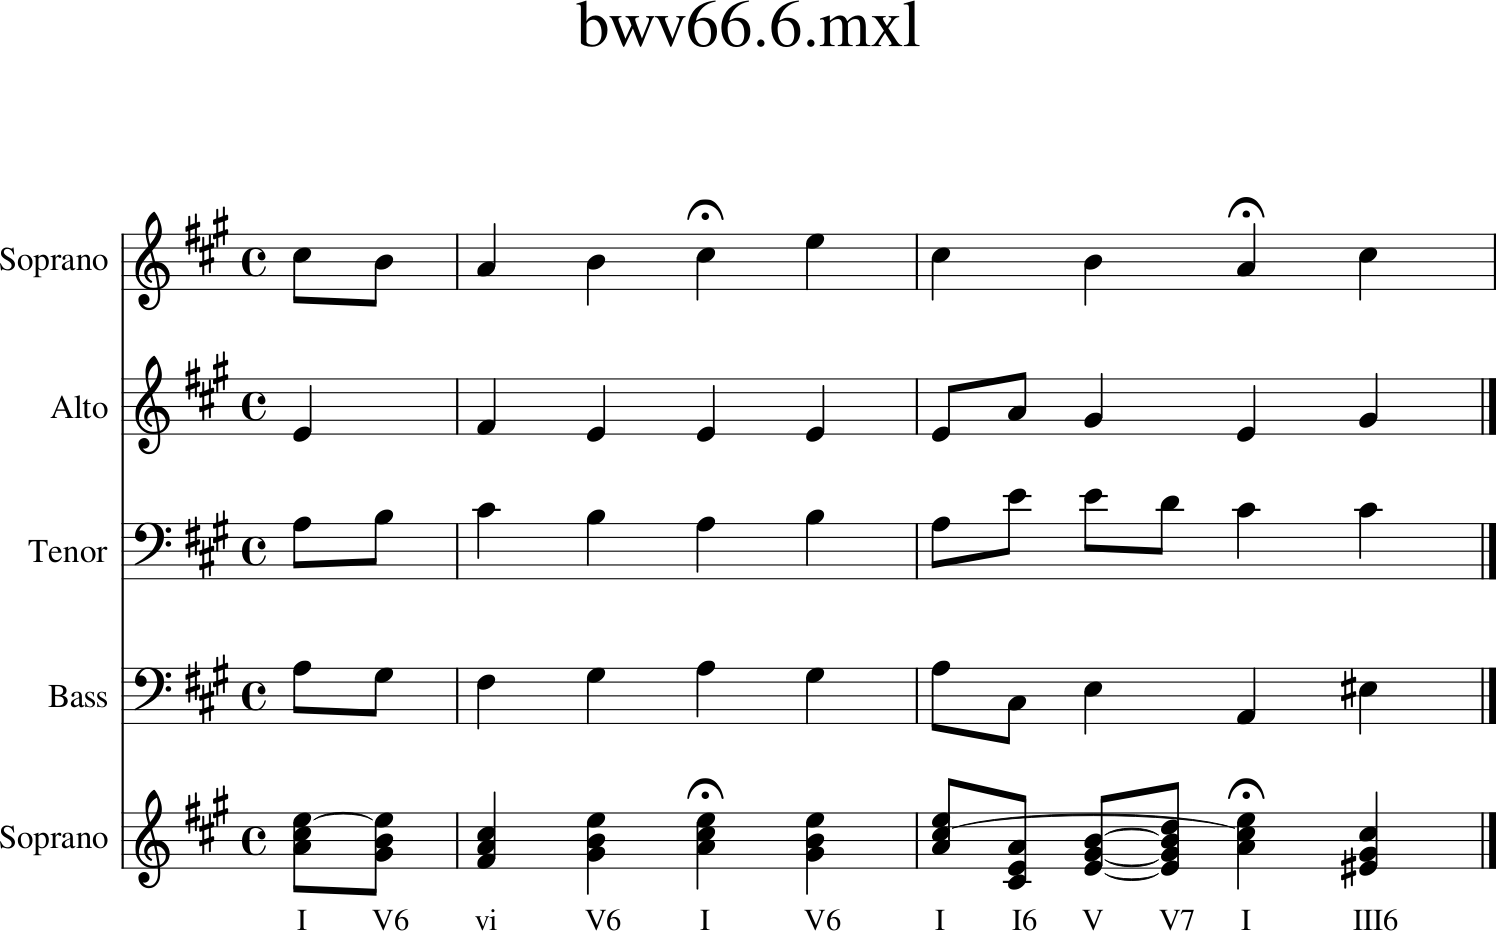

In [6]:
for c in bChords.recurse().getElementsByClass('Chord'):
    rn = roman.romanNumeralFromChord(c, key.Key('A'))
    c.addLyric(str(rn.figure))

b.measures(0, 2).show()

也可以用`.show('text')`以文本形式查看：

In [7]:
bChords.measures(0, 2).show('text')

{0.0} <music21.instrument.Instrument 'P1: Soprano: Instrument 1'>
{0.0} <music21.stream.Measure 0 offset=0.0>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.key.Key of f# minor>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.chord.Chord A4 C#5 E5>
    {0.5} <music21.chord.Chord G#4 B4 E5>
{1.0} <music21.stream.Measure 1 offset=1.0>
    {0.0} <music21.chord.Chord F#4 A4 C#5>
    {1.0} <music21.chord.Chord G#4 B4 E5>
    {2.0} <music21.chord.Chord A4 C#5 E5>
    {3.0} <music21.chord.Chord G#4 B4 E5>
{5.0} <music21.stream.Measure 2 offset=5.0>
    {0.0} <music21.chord.Chord A4 C#5 E5>
    {0.5} <music21.chord.Chord C#4 E4 A4>
    {1.0} <music21.chord.Chord E4 G#4 B4>
    {1.5} <music21.chord.Chord E4 G#4 B4 D5>
    {2.0} <music21.chord.Chord A4 C#5 E5>
    {3.0} <music21.chord.Chord E#4 G#4 C#5>


或者提取歌词，也就是我们刚刚自动分析的和弦类型：

In [8]:
for c in bChords.measures(0, 2).recurse():
    if 'Chord' not in c.classes:
        continue
    print(c.lyric, end=' ')

I V6 vi V6 I V6 I I6 V V7 I III6 

## 使用和弦化标注音程
使用`chordify`和`annotateIntervals`标注音程是分析乐谱的一种有效手段。我们使用上一章中介绍的多音轨opus ABC文件作为例子来演示这一流程。

In [9]:
o = corpus.parse('josquin/laDeplorationDeLaMorteDeJohannesOckeghem')
for s in o:
    print(s)

<music21.stream.Score 0x19f499911c0>
<music21.stream.Score 0x19f489a6af0>
<music21.stream.Score 0x19f49c46e80>
<music21.stream.Score 0x19f49d09f40>
<music21.stream.Score 0x19f49d77550>


现在我们有多个乐谱，我们先把它们合并为一个乐谱——用多个乐谱存储多个音轨的情况，尽管较少使用，但仍然会偶尔遇到，所以我们将其合并：

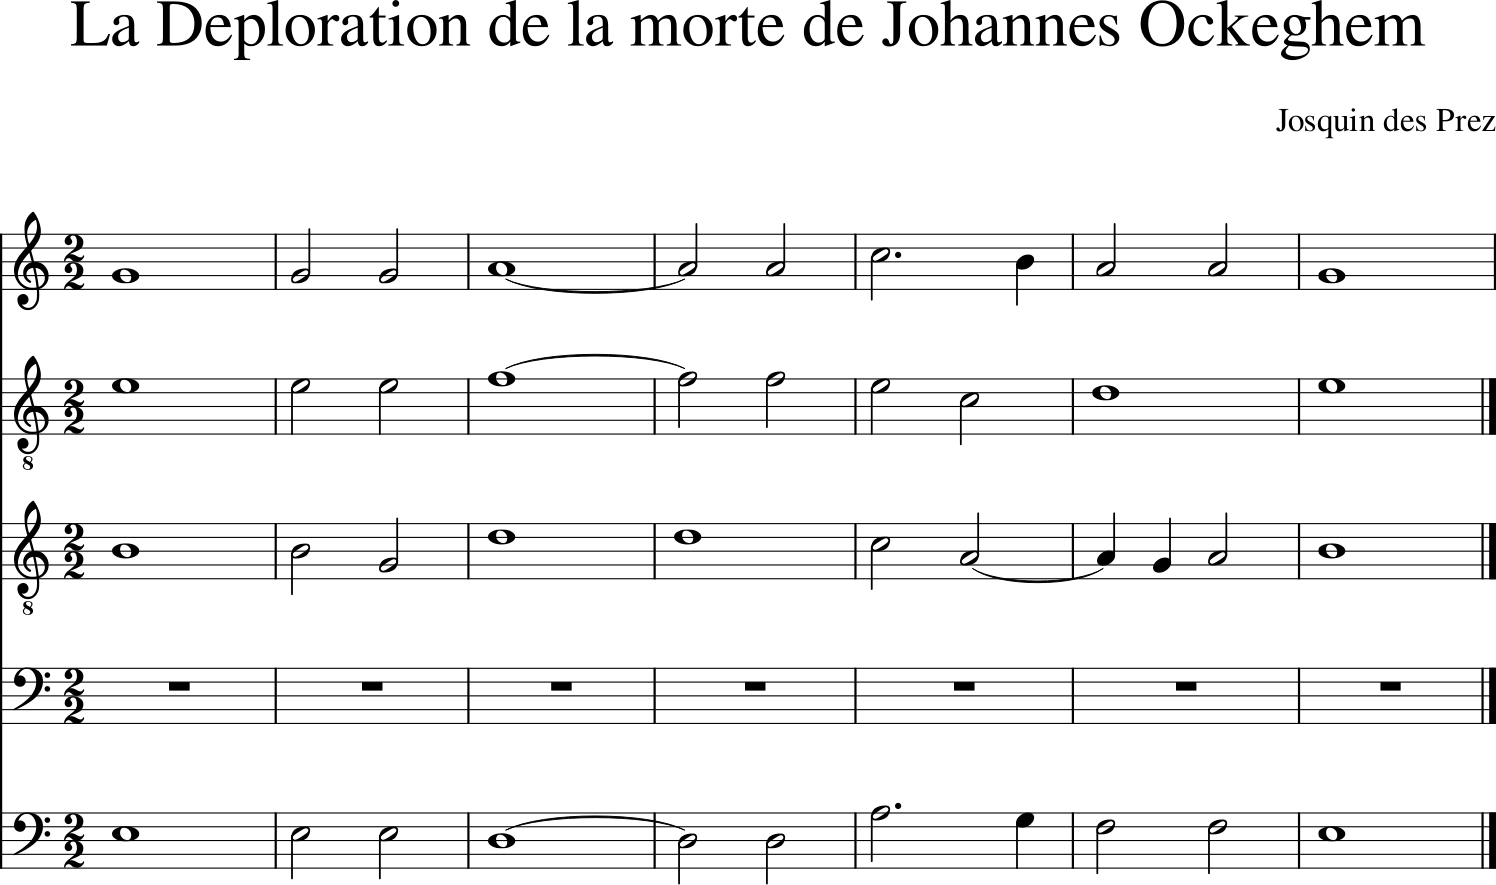

In [10]:
mergedScores = o.mergeScores()
scoreExcerpt = mergedScores.measures(127, 133)
scoreExcerpt.show()

和弦化：

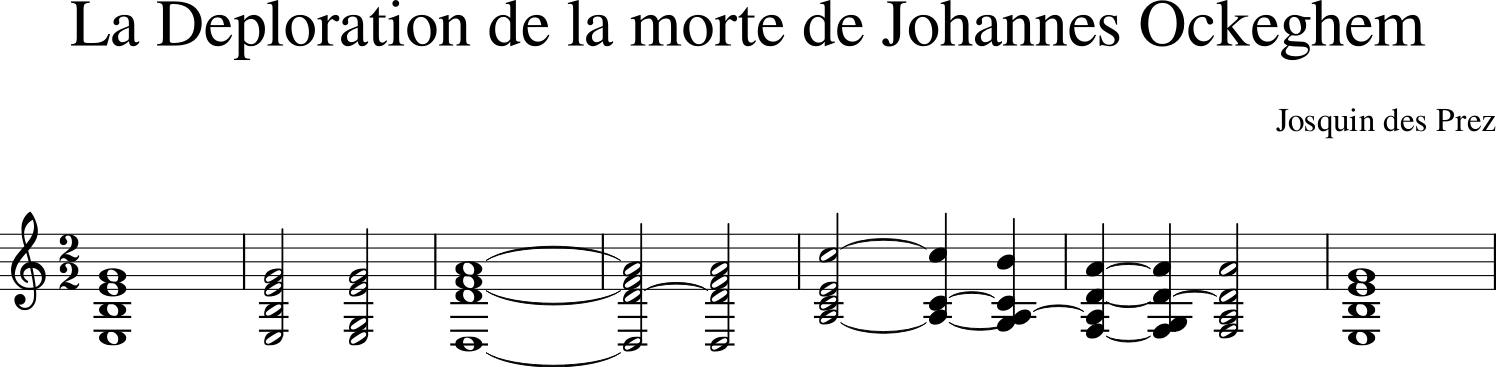

In [11]:
reduction = scoreExcerpt.chordify()
reduction.show()

遍历和弦，缩紧到第4个八度，然后运行`annotateIntervals`命令：

In [12]:
for c in reduction.recurse().getElementsByClass('Chord'):
    c.closedPosition(forceOctave=4, inPlace=True)
    c.annotateIntervals()

将结果放回原来的总谱并显示。使用`insert`将其添加到乐谱的0时刻，而不是`append`，这是因为各个音轨从同一时刻开始。此外，删去空白的第4音轨。

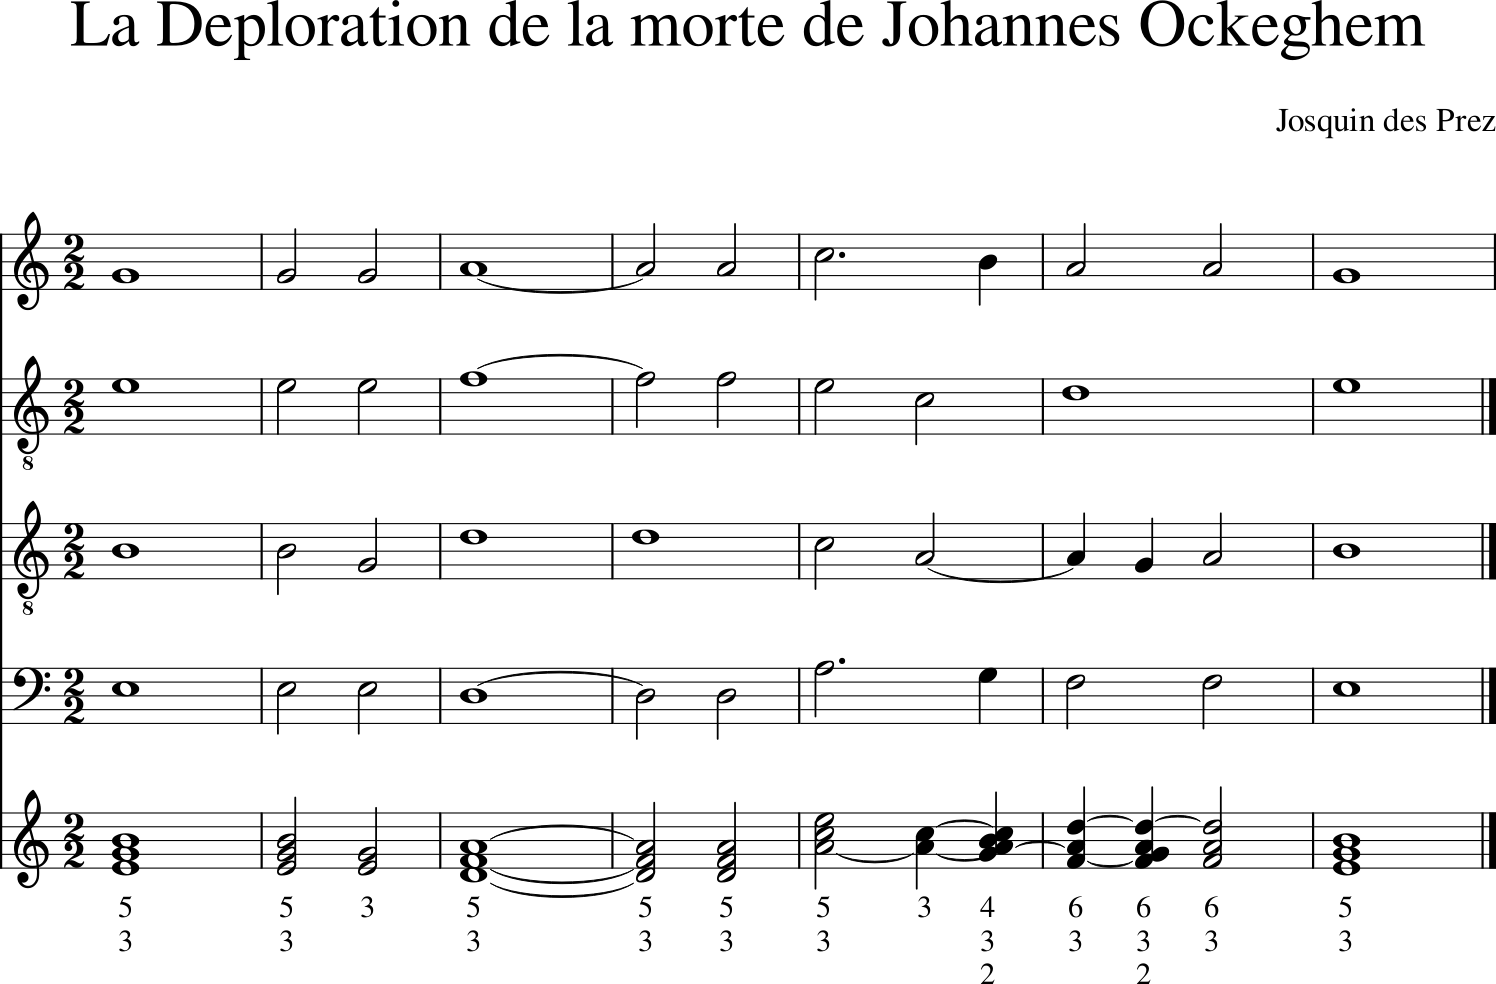

In [13]:
scoreExcerpt.insert(0, reduction)
emptyPart = scoreExcerpt.parts[3]
scoreExcerpt.remove(emptyPart)
scoreExcerpt.show()

音程已经作为歌词添加到和弦中：

In [14]:
for c in reduction.recurse().getElementsByClass('Chord'):
    print(c, end=" ")
    for l in c.lyrics:
        print(l.text, end=" ")
    print()

<music21.chord.Chord E4 G4 B4> 5 3 
<music21.chord.Chord E4 G4 B4> 5 3 
<music21.chord.Chord E4 G4> 3 
<music21.chord.Chord D4 F4 A4> 5 3 
<music21.chord.Chord D4 F4 A4> 5 3 
<music21.chord.Chord D4 F4 A4> 5 3 
<music21.chord.Chord A4 C5 E5> 5 3 
<music21.chord.Chord A4 C5> 3 
<music21.chord.Chord G4 A4 B4 C5> 4 3 2 
<music21.chord.Chord F4 A4 D5> 6 3 
<music21.chord.Chord F4 G4 A4 D5> 6 3 2 
<music21.chord.Chord F4 A4 D5> 6 3 
<music21.chord.Chord E4 G4 B4> 5 3 


从这里开始，我们可以发现有趣的地方，例如第5小节末尾的“4321”和弦。

## 复杂乐谱的和弦化
复杂的乐谱也能进行和弦化。如果乐谱包含大量三连音，可能会得到奇怪的结果。例如Arnold Schoenberg的Opus 19, no. 6。

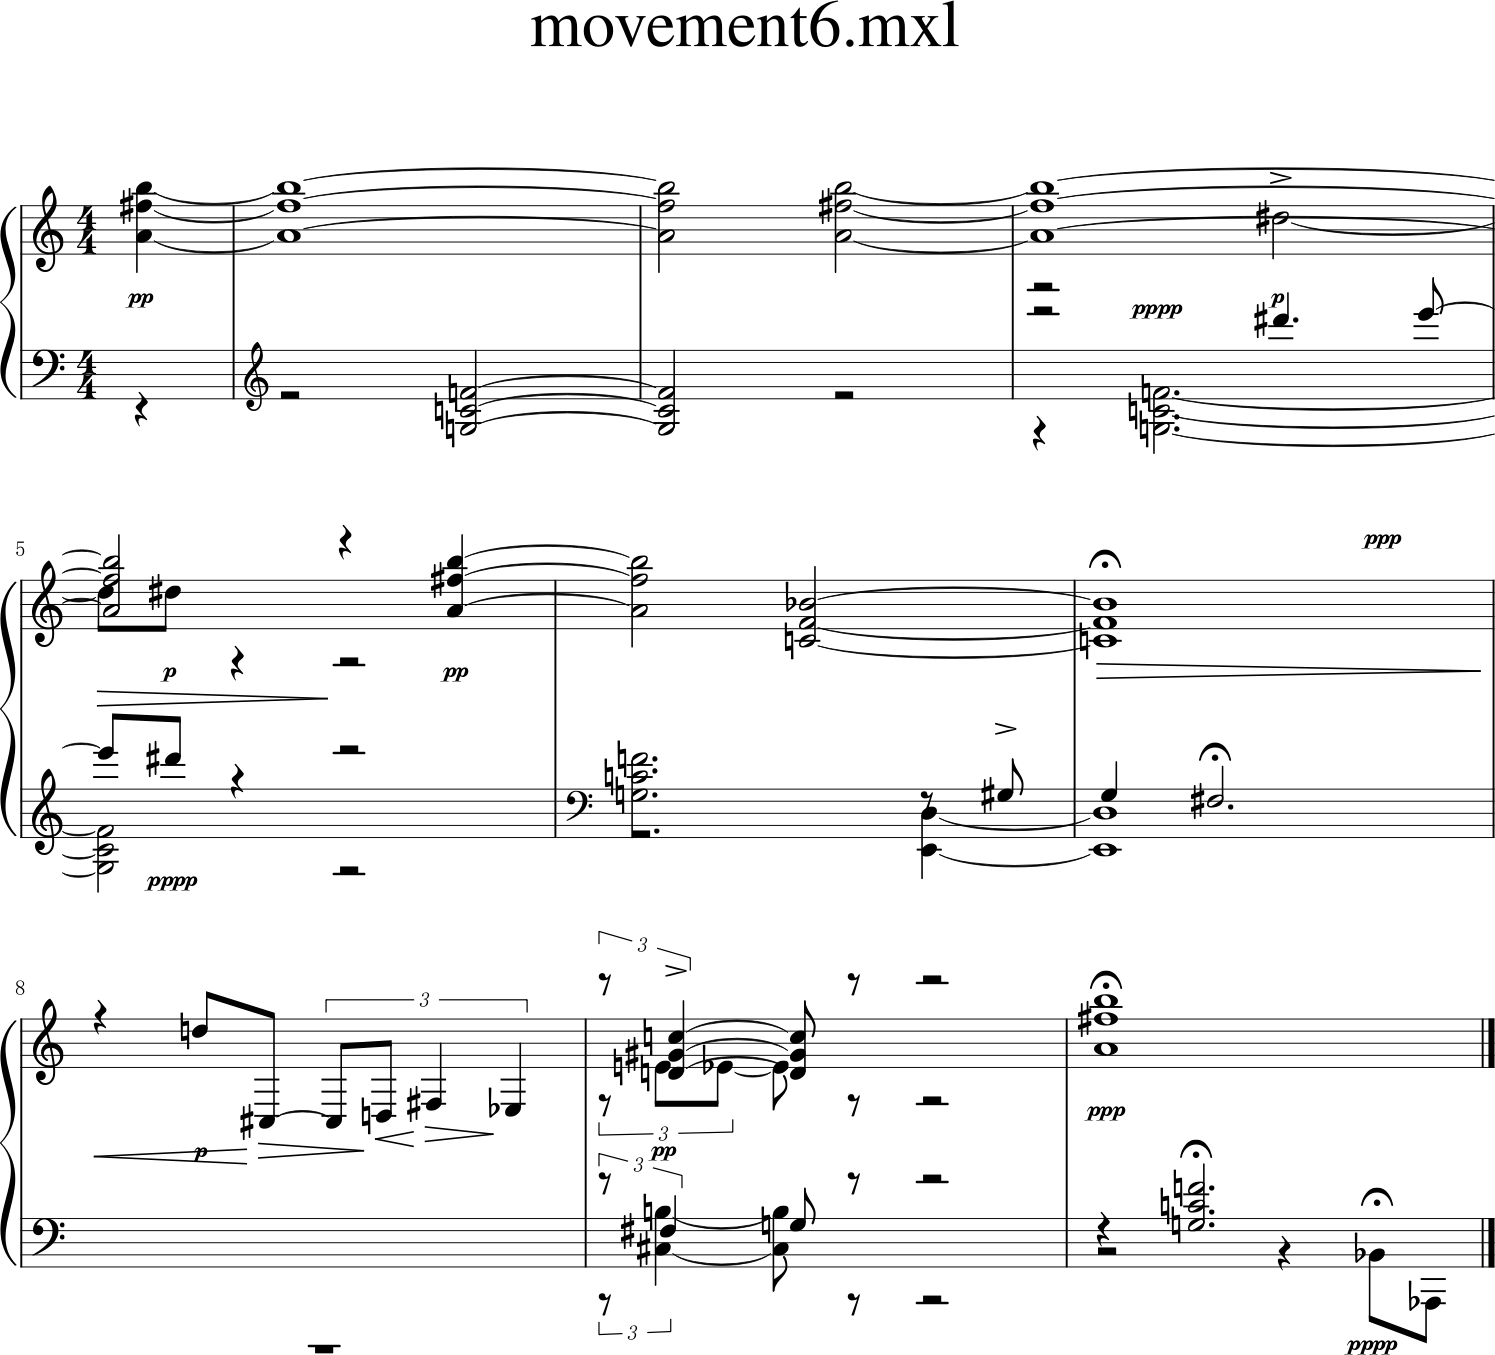

In [15]:
schoenberg = corpus.parse('schoenberg/opus19', 6)
schoenberg.show()

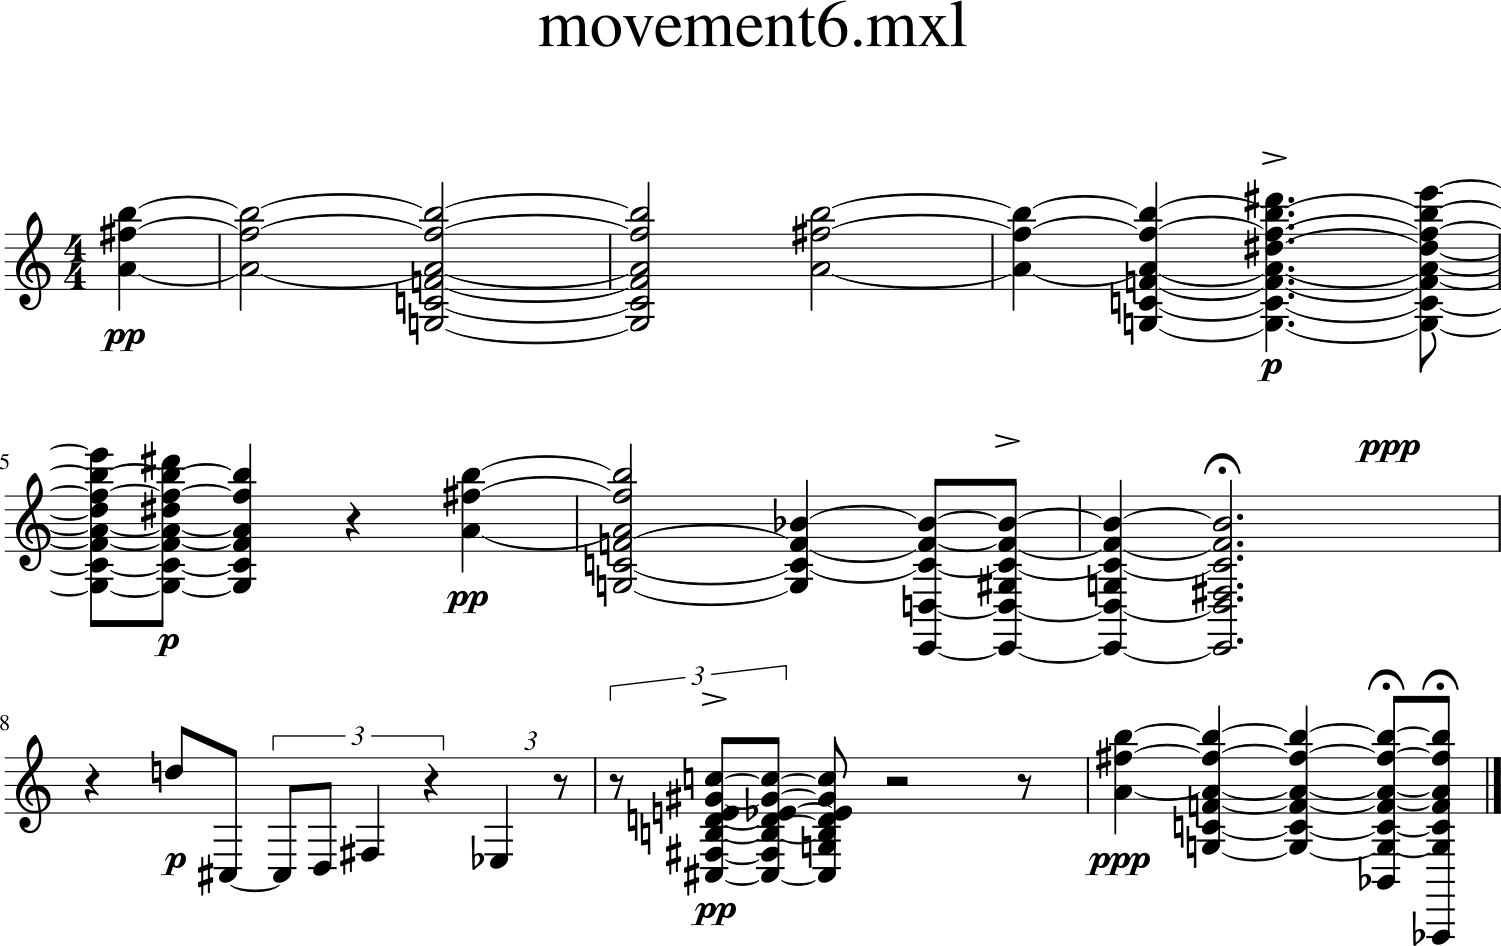

In [16]:
chorded = schoenberg.chordify()
chorded.show()

`chordify`有更多的用法，可参考`chordify()`的文档。我们会在后面介绍`addPartIdAsGroup`，能显示和弦中的每个音符分别来自哪里。
[用户指南，第10章：案例1](10.ipynb)